In [1]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread
import tensorflow.keras as keras
import tensorflow as tf

from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

In [20]:
def plot_img(images, row=5, col=5, img_size=(5, 5)):
    plt.figure(figsize=(col * img_size[0], row * img_size[1]))  # Adjust figure size

    for i, img in enumerate(images[:row * col]):
        if isinstance(img, str):  # If it's a file path, read it
            img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        elif isinstance(img, np.ndarray):  # If it's already an image array
            img = img  
        else:
            print(f"Skipping {i}: Invalid type {type(img)}")
            continue
        
        plt.subplot(row, col, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.show()



In [16]:
class readDataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape
    def imagesPath(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath, 
                                                folder)).glob('*{}.*'.format(name)))
        return images
    def readImages(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels = channels)
            image = tf.image.resize(image, self.imageShape)
            image/= 255
            listImages.append(image)
        return listImages
    def allDataset(self, label):
        images = self.readImages(self.imagesPath(label, name = ')'), channels = 3)
        masks = np.array(self.readImages(self.imagesPath(label, name = 'mask'), channels = 1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks
    def finalDataset(self, labels):
        images_benign, masks_benign = self.allDataset(labels[0])
        images_malignant, masks_malignant = self.allDataset(labels[1])
        images_normal, masks_normal = self.allDataset(labels[2])
        images = np.vstack([images_benign, images_malignant, images_normal])
        masks = np.vstack([masks_benign, masks_malignant, masks_normal])
        labels = np.hstack([np.ones(shape = (len(images_benign),))*0,
                           np.ones(shape = (len(images_malignant), ))*1, 
                           np.ones(shape = (len(images_normal), ))*2])
        return images, masks, labels
    def dataAugmentation(self, images, masks, labels):
        imagesupdate = []
        masksupdate = []
        labelsupdate = []
        for image, mask, label in zip(images, labels, masks):
            image1 = tf.image.adjust_contrast(image, contrast_factor = 2)
            image2 = tf.image.adjust_brightness(image, delta = 0.3)
            imagesupdate.append(image), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image1), masksupdate.append(mask), labelsupdate.append(label)
            imagesupdate.append(image2), masksupdate.append(mask), labelsupdate.append(label)
        return np.array(imagesupdate), np.array(masksupdate), np.array(labelsupdate)


In [18]:
import pathlib
datasetpath = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
datasetObject = readDataset(datasetpath, [128, 128])
images, masks, labels = datasetObject.finalDataset(['benign', 'malignant', 'normal'])

In [19]:
images, masks, labels = datasetObject.dataAugmentation(images, labels, masks)
images.shape, masks.shape, labels.shape


((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

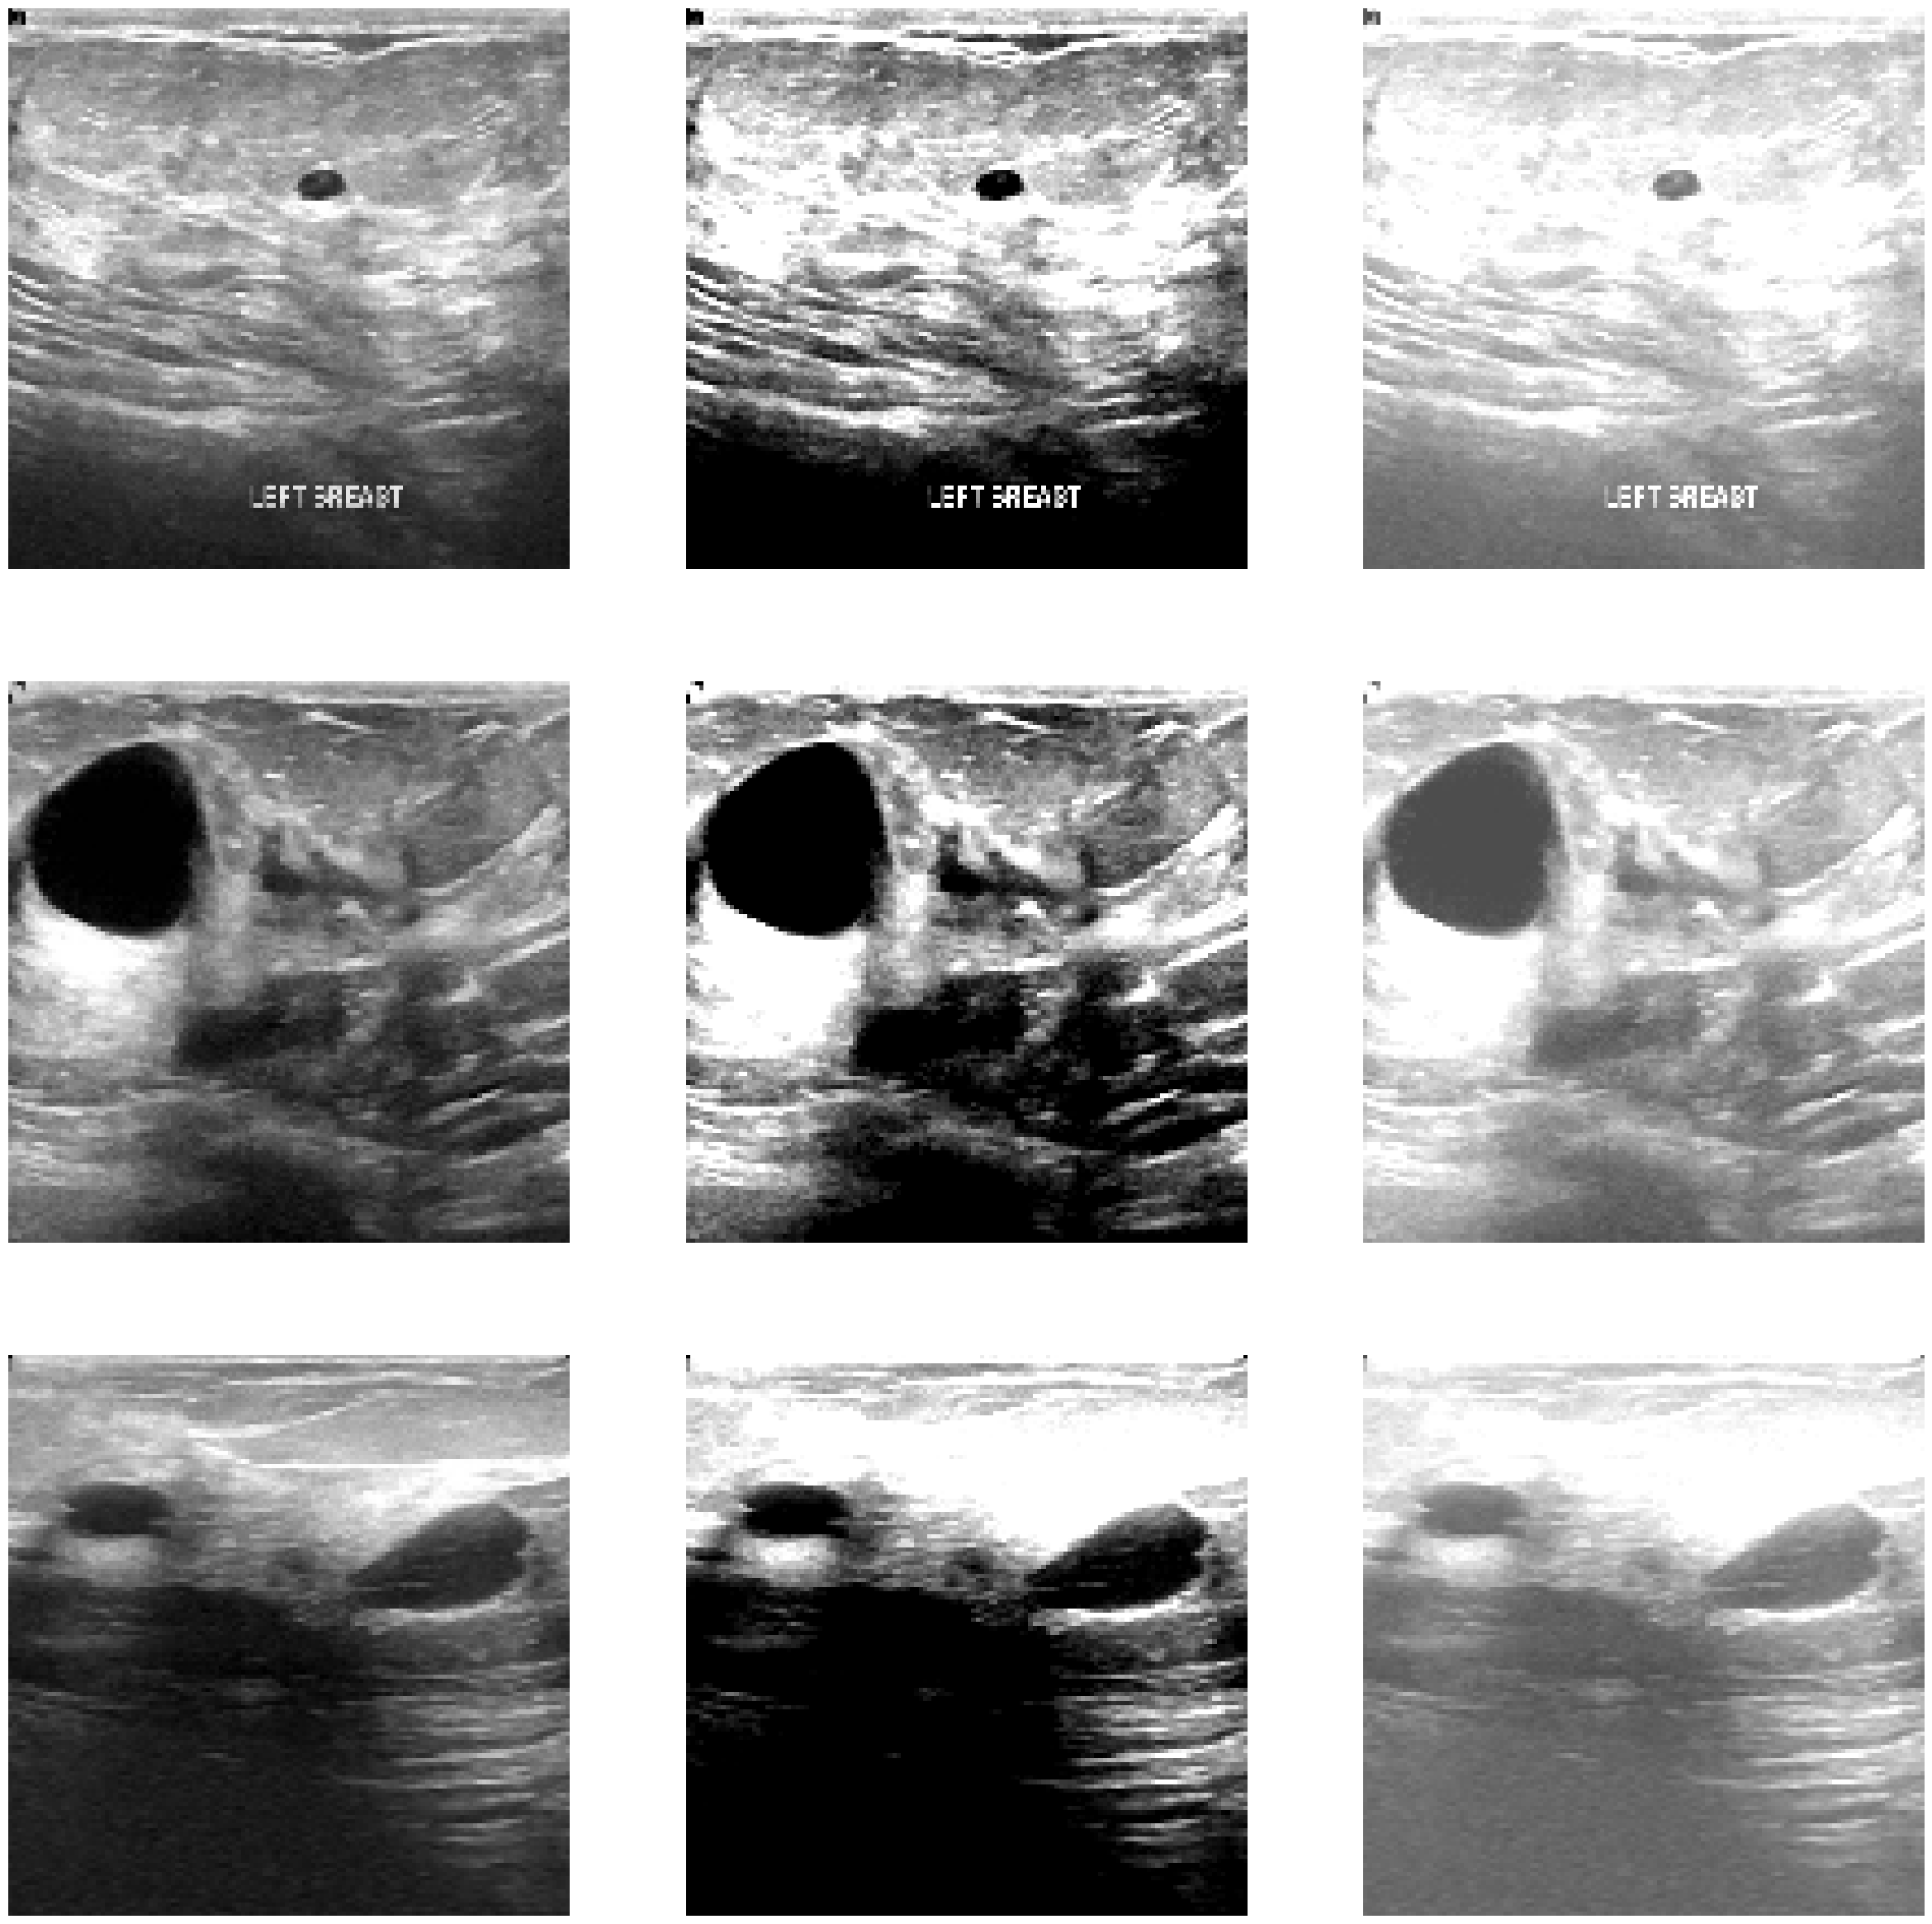

In [21]:
plot_img(images, row=3, col=3, img_size=(10, 10))


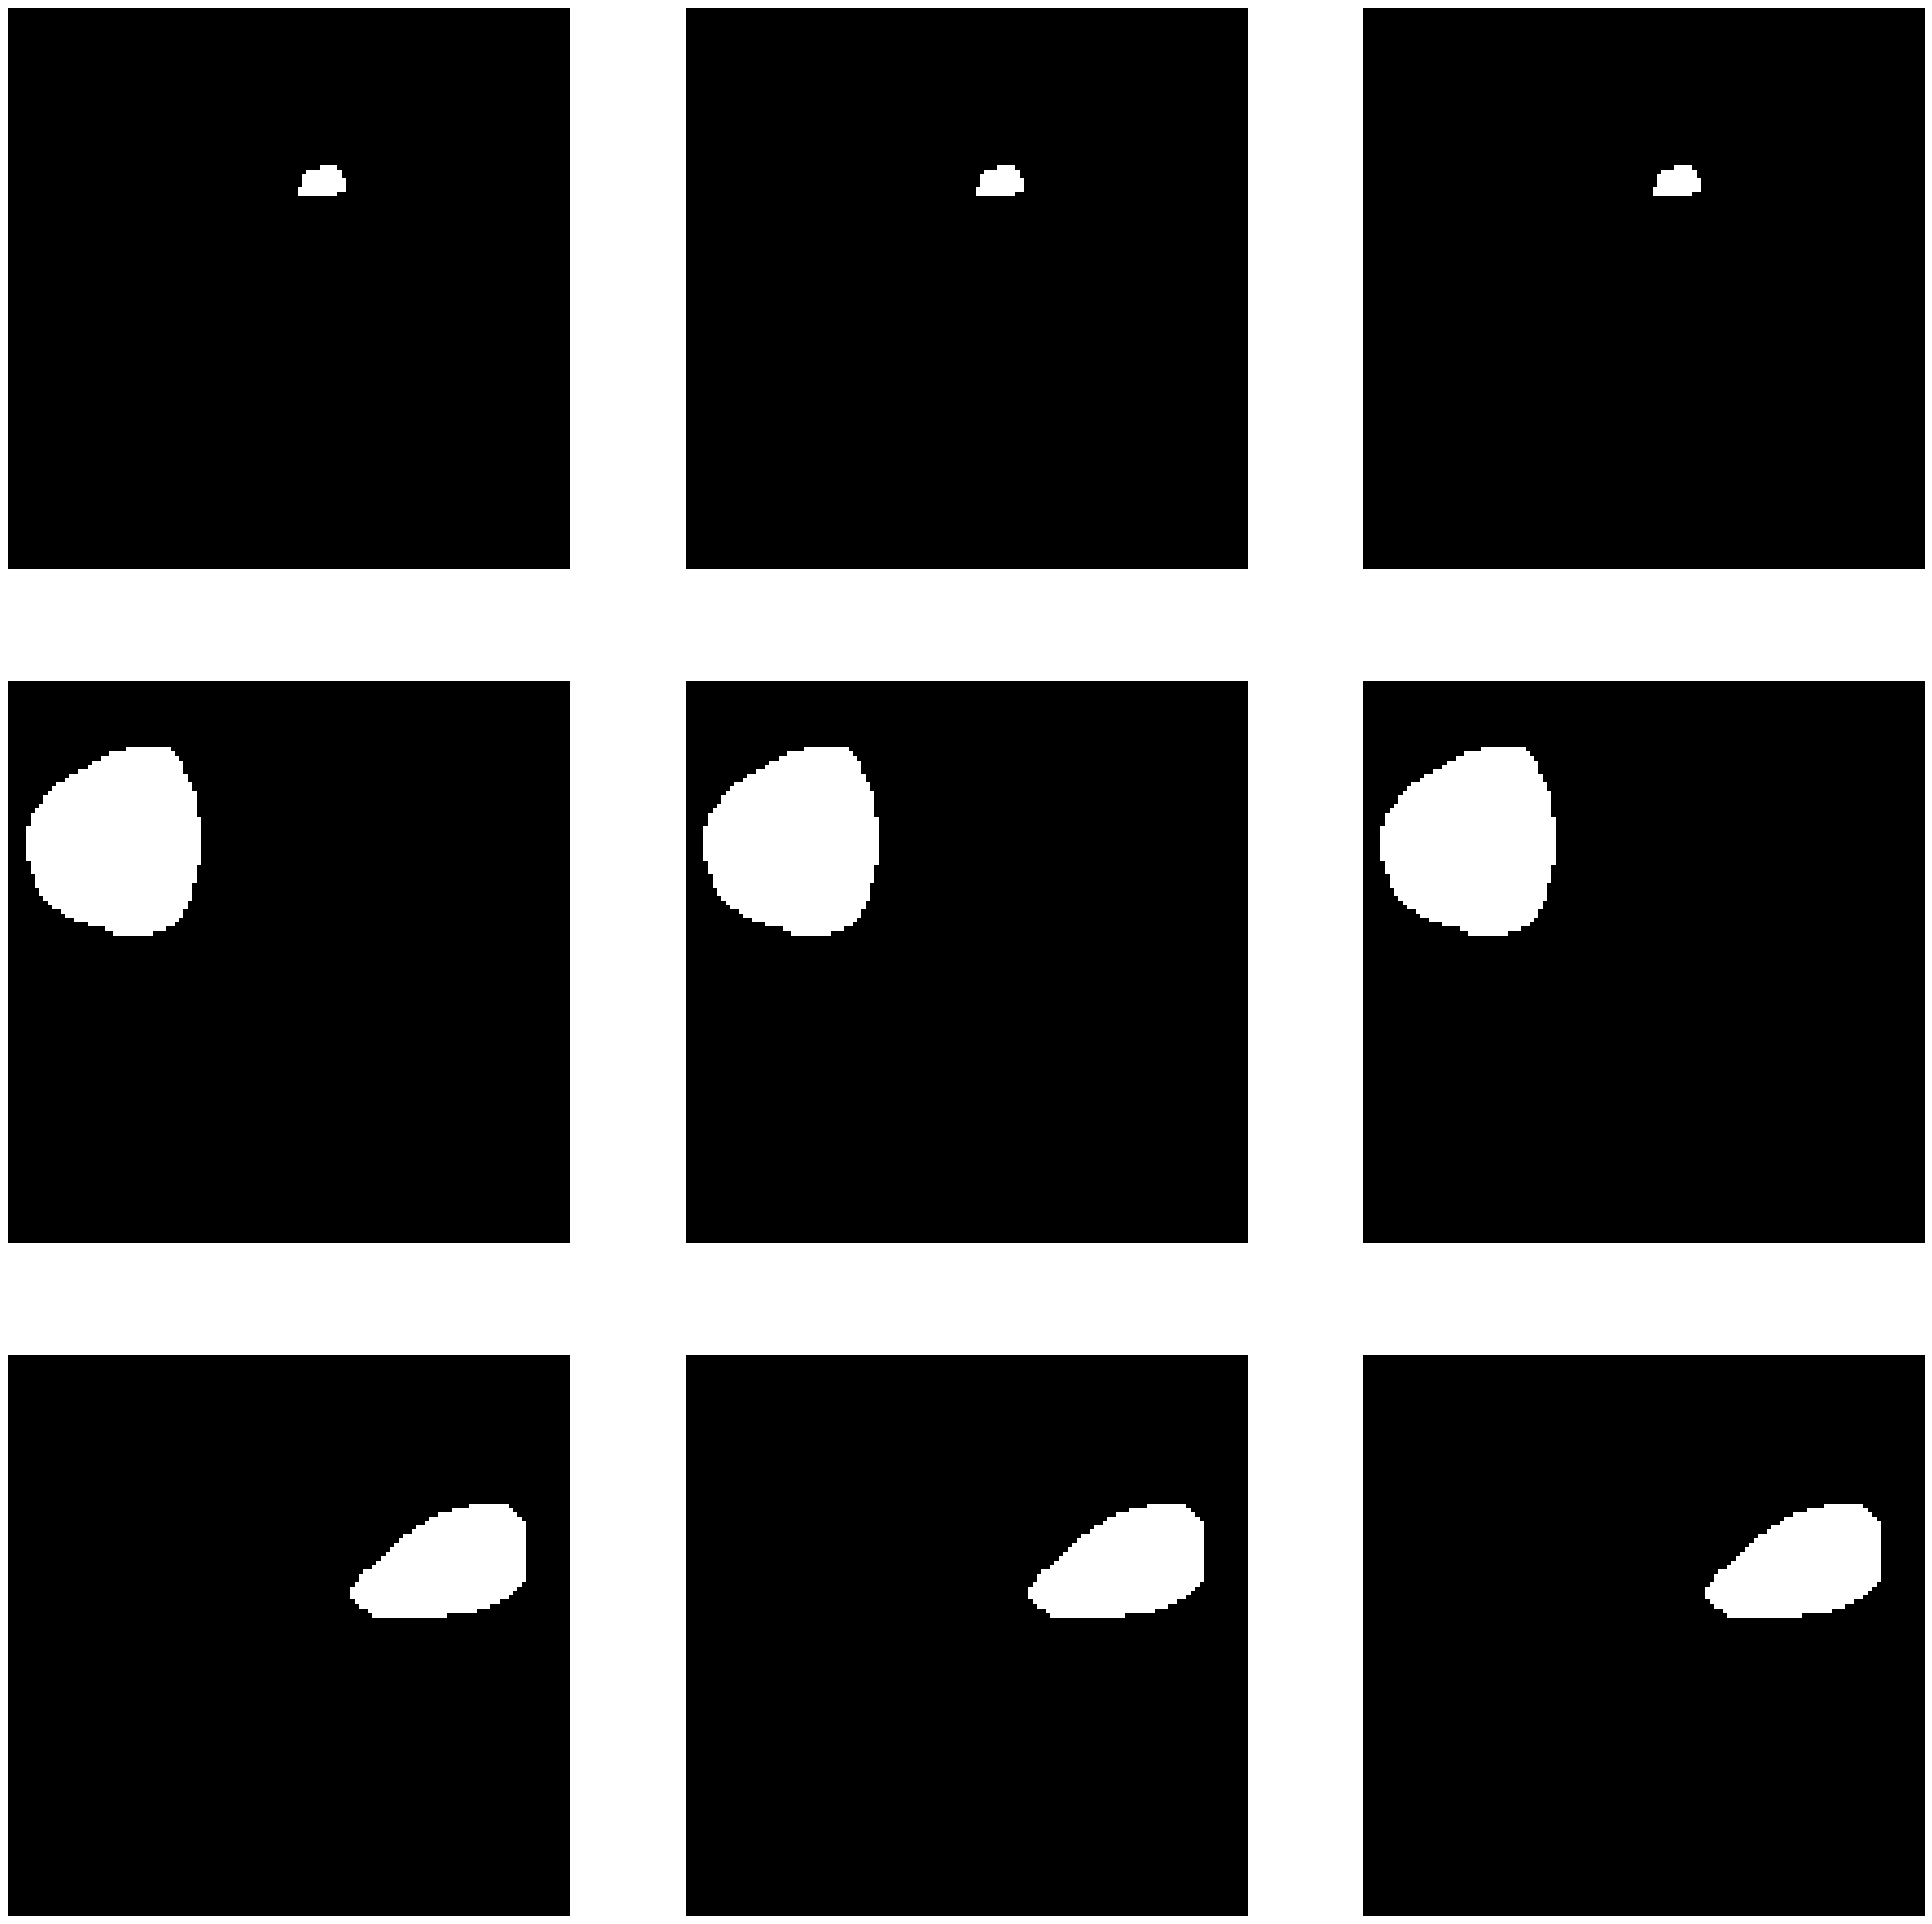

In [22]:
plot_img(masks, row=3, col=3, img_size=(10, 10))

In [47]:
def convolution(inputs, padding, strides, filter, kernel_size):
    x = inputs
    y = layers.Conv2D(filter, kernel_size = 1, padding = padding, 
                     strides = strides, 
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding, 
                     strides = strides, 
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(y)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding, 
                     strides = strides, 
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, y])
    x = layers.Activation('relu')(x)
    return x

In [51]:
def encoder(inputs, filter):
    correlation = convolution(inputs, padding = 'same', strides = 1, filter = filter, 
                             kernel_size = 5)
    downsample = layers.AveragePooling2D(pool_size=(2, 2))(correlation)
    return correlation, downsample

In [52]:
def decoder(inputs, skip_connection, filter):
    upsample = layers.Conv2DTranspose(filter, 5, padding = 'same', strides = 2, 
                                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(inputs)
    upsample = layers.Activation('relu')(upsample)
    upsample = layers.BatchNormalization()(upsample)
    connection = layers.average([upsample, skip_connection])
    correlation = convolution(connection, padding = 'same', strides = 1, filter = filter, 
                             kernel_size = 5)
    return correlation

In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.metrics import Precision, Recall

In [65]:
input = layers.Input(shape = (128, 128, 3))
filter = 32
corr1, downsample1 = encoder(input, filter)
corr2, downsample2 = encoder(downsample1, filter*2)
corr3, downsample3 = encoder(downsample2, filter*4)
corr4, downsample4 = encoder(downsample3, filter*8)
downsample4 = convolution(downsample4, padding = 'same', strides = 1, filter = filter*8, 
                         kernel_size = 5)
features_vector_1 = layers.GlobalAveragePooling2D()(downsample4)
features_vector_2 = layers.Flatten()(downsample4)
features_vector_2 = layers.Dropout(0.5)(features_vector_2)
features_vector_1 = layers.Dropout(0.5)(features_vector_1)
encoder_x = layers.Dense(64, name = 'latent_space', 
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(features_vector_1)
x = layers.Dense(downsample4.shape[1]*downsample4.shape[2]*downsample4.shape[3], 
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(encoder_x)
x = layers.Reshape((downsample4.shape[1], downsample4.shape[2], downsample4.shape[3]), 
                  name = 'reshape')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
decoder_corr1 = decoder(x, corr4, filter*8)
decoder_corr2 = decoder(decoder_corr1, corr3, filter*4)
decoder_corr3 = decoder(decoder_corr2, corr2, filter*2)
decoder_corr4 = decoder(decoder_corr3, corr1, filter)
output = layers.Conv2DTranspose(1, 5, padding = 'same', strides = 1)(decoder_corr4)
output = layers.Activation('sigmoid', name = 'UNET')(output)
labelOutput = layers.Dense(32, activation = 'relu')(features_vector_2)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(16, activation = 'relu')(labelOutput)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(1, name = 'label')(labelOutput)
m = models.Model(inputs = input, outputs = [output, labelOutput])
m.compile(
    loss={
        'UNET': lambda y_true, y_pred: ConditionalSegmentationLoss()(y_true, y_pred, m.output[0]),  # Fix model reference
        'label': tf.keras.losses.BinaryCrossentropy()  # Use BinaryCrossentropy for binary classification
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics={
        'UNET': ['accuracy'],  # Ensure name matches the model output name
        'label': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    }
)

m.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_210 (Conv2D)       │ (None, 128, 128, 32)   │            128 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_211 (Conv2D)       │ (None, 128, 128, 32)   │         25,632 │ conv2d_210[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_231   │ (None, 128, 128, 32)   │            128 │ conv2d_211[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_112            │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_212 (Conv2D)       │ (None, 128, 128, 32)   │         25,632 │ activation_112[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_232   │ (None, 128, 128, 32)   │            128 │ conv2d_212[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_46 (Add)              │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d_210[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_113            │ (None, 128, 128, 32)   │              0 │ add_46[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_20      │ (None, 64, 64, 32)     │              0 │ activation_113[0][0]   │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_213 (Conv2D)       │ (None, 64, 64, 64)     │          2,112 │ average_pooling2d_20[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_214 (Conv2D)       │ (None, 64, 64, 64)     │        102,464 │ conv2d_213[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_233   │ (None, 64, 64, 64)     │            256 │ conv2d_214[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_114            │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_215 (Conv2D)       │ (None, 64, 64, 64)     │        102,464 │ activation_114[0][0]   │
├──────────────────────

 Total params: 16,514,146 (63.00 MB)

 Trainable params: 16,507,714 (62.97 MB)

 Non-trainable params: 6,432 (25.12 KB)

In [56]:
tf.keras.utils.plot_model(m,
                            show_shapes=True,
                            show_layer_names=True,)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.965951 to fit



In [66]:
history = m.fit(trainDataset[0], [trainDataset[1], trainDataset[2]], epochs = 260, 
               validation_data = (validDataset[0], [validDataset[1], validDataset[2]]), 
               batch_size = 8, callbacks = [
                   tf.keras.callbacks.EarlyStopping(patience = 12, monitor = 'val_loss', 
                                                   mode = 'min', restore_best_weights = True)
               ])

Epoch 1/260


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [64]:
print([layer.name for layer in m.output])


['keras_tensor_1159', 'keras_tensor_1166']


In [28]:
randomIndexs = np.random.randint(0, len(images), size = (len(images), ))
images = images[randomIndexs]
masks = masks[randomIndexs]
labels = labels[randomIndexs]
images.shape, masks.shape, labels.shape

((2340, 128, 128, 3), (2340, 128, 128, 1), (2340,))

In [29]:
valid = 500
trainDataset = [images[:images.shape[0] - valid], 
         masks[:images.shape[0] - valid], 
         labels[:images.shape[0] - valid]]
validDataset = [images[images.shape[0] - valid:], 
         masks[images.shape[0] - valid:], 
         labels[images.shape[0] - valid:]]

In [30]:

trainDataset[0].shape, trainDataset[1].shape, trainDataset[2].shape

((1840, 128, 128, 3), (1840, 128, 128, 1), (1840,))

In [67]:
class readDataset:
    def __init__(self, datasetpath, imageShape):
        self.datasetpath = datasetpath
        self.imageShape = imageShape
    def imagesPath(self, folder, name):
        images = list(pathlib.Path(os.path.join(self.datasetpath,
                                                folder)).glob('*{}.*'.format(name)))
        return images
    def readImages(self, images, channels):
        listImages = []
        images = np.sort(images)
        for image in images:
            image = tf.io.read_file(str(image))
            image = tf.image.decode_png(image, channels = channels)
            image = tf.image.resize(image, self.imageShape)
            image/= 255
            listImages.append(image)
        return listImages
    def allDataset(self, label):
        images = self.readImages(self.imagesPath(label, name = ')'), channels = 3)
        masks = np.array(self.readImages(self.imagesPath(label, name = 'mask'), channels = 1))
        masks = (masks >= 0.5).astype('int32')
        return np.array(images), masks
    def finalDataset(self, labels):
        images_benign, masks_benign = self.allDataset(labels[0])
        images_malignant, masks_malignant = self.allDataset(labels[1])
        images_normal, masks_normal = self.allDataset(labels[2])
        images = np.vstack([images_benign, images_malignant, images_normal])
        masks = np.vstack([masks_benign, masks_malignant, masks_normal])
        labels = np.hstack([np.ones(shape = (len(images_benign),))*0,
                           np.ones(shape = (len(images_malignant), ))*1,
                           np.ones(shape = (len(images_normal), ))*2])
        return images, masks, labels
    def dataAugmentation(self, images, masks, labels):
        imagesupdate = []
        masksupdate = []
        labelsupdate = []
        for image, mask, label in zip(images, labels, masks):
          for aug in range(5):
            imageup = image
            maskup = mask
            if aug == 0:
              imageup = image
              maskup = mask
            elif aug == 1:
              imageup = tf.image.adjust_contrast(imageup, contrast_factor = 2)
            elif aug == 2:
              imageup = tf.image.adjust_brightness(imageup, delta = 0.3)
            elif aug == 3:
              imageup = tf.image.flip_left_right(imageup)
              maskup = tf.image.flip_left_right(maskup)
            else:
              imageup = cv2.GaussianBlur(imageup,(5, 5),0)
            imagesupdate.append(imageup), masksupdate.append(maskup), labelsupdate.append(label)
        return np.array(imagesupdate), np.array(masksupdate), np.array(labelsupdate)

In [68]:
datasetpath = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
datasetObject = readDataset(datasetpath, [128, 128])
images, masks, labels = datasetObject.finalDataset(['benign', 'malignant', 'normal'])

In [69]:
images, masks, labels = datasetObject.dataAugmentation(images, labels, masks)
images.shape, masks.shape, labels.shape

((3900, 128, 128, 3), (3900, 128, 128, 1), (3900,))

In [70]:
def showImagesWithMask(images, masks, labels):
    plt.figure(figsize = (12, 12))
    for i in range(len(images)):
        plt.subplot(8, 8, (i + 1))
        plt.imshow(images[i])
        plt.imshow(masks[i], alpha = 0.3, cmap = 'jet')
        plt.title(labels[i])
    plt.legend()

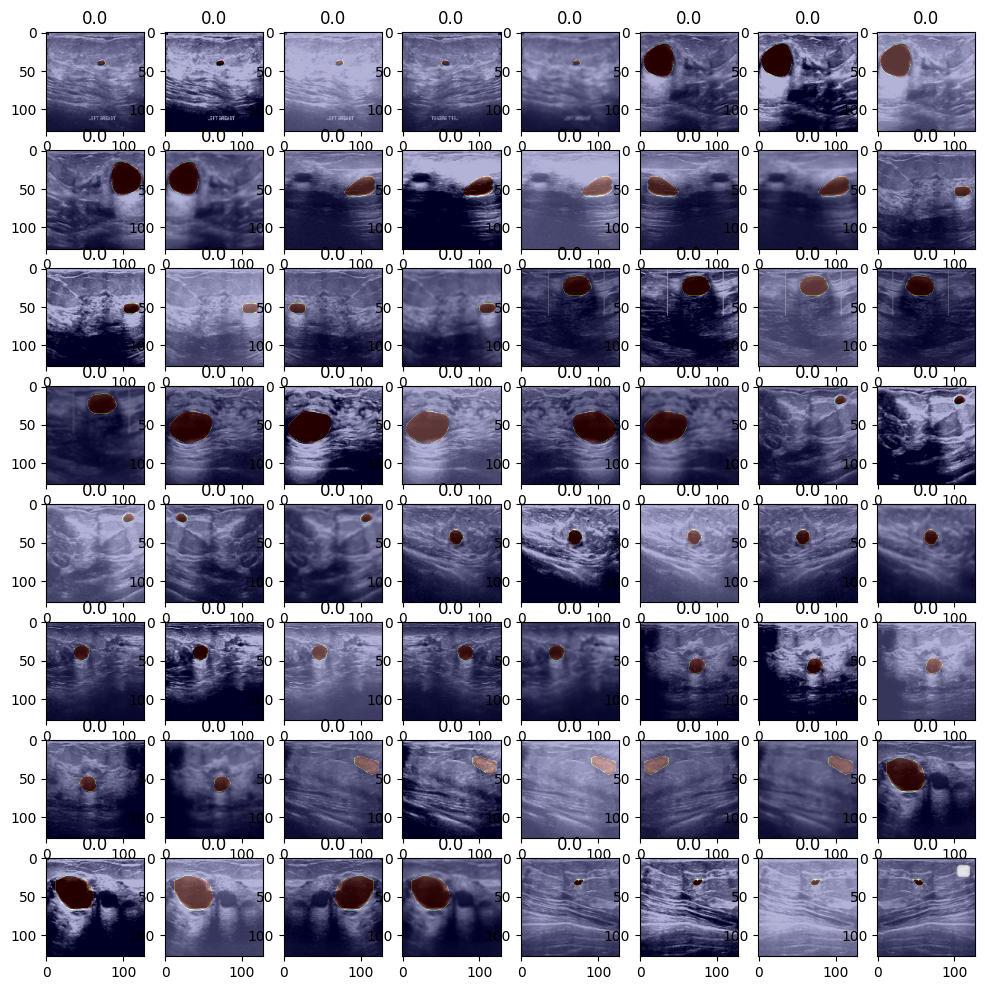

In [71]:
showImagesWithMask(images[:64], masks[:64], labels[:64])

In [72]:
randomIndexs = np.random.randint(0, len(images), size = (len(images), ))
images = images[randomIndexs]
masks = masks[randomIndexs]
labels = labels[randomIndexs]
images.shape, masks.shape, labels.shape

((3900, 128, 128, 3), (3900, 128, 128, 1), (3900,))

In [73]:
valid = int(len(images)*0.15)
trainDataset = [images[:images.shape[0] - valid],
         masks[:images.shape[0] - valid],
         labels[:images.shape[0] - valid]]
validDataset = [images[images.shape[0] - valid:],
         masks[images.shape[0] - valid:],
         labels[images.shape[0] - valid:]]

In [74]:
trainDataset[0].shape, trainDataset[1].shape, trainDataset[2].shape

((3315, 128, 128, 3), (3315, 128, 128, 1), (3315,))

In [76]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
curr = layers.Flatten()(trainDataset[0])
scaler.fit(curr)
trainImages = scaler.transform(curr)
validImages = scaler.transform(layers.Flatten()(validDataset[0]))
trainDataset[0] = np.reshape(trainImages, (trainDataset[0].shape[0], 128, 128, 3))
validDataset[0] = np.reshape(validImages, (validDataset[0].shape[0], 128, 128, 3))
trainDataset[0].shape, validDataset[0].shape

((3315, 128, 128, 3), (585, 128, 128, 3))

In [77]:
def convolution(inputs, padding, strides, filter, kernel_size):
    x = inputs
    y = layers.Conv2D(filter, kernel_size = 1, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(y)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter, kernel_size = kernel_size, padding = padding,
                     strides = strides,
                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, y])
    x = layers.Activation('relu')(x)
    return x

In [81]:
def encoder(inputs, filter):
    correlation = convolution(inputs, padding = 'same', strides = 1, filter = filter,
                             kernel_size = 5)
    downsample = layers.AveragePooling2D(pool_size=(2, 2))(correlation)
    return correlation, downsample

In [82]:
def decoder(inputs, skip_connection, filter):
    upsample = layers.Conv2DTranspose(filter, 5, padding = 'same', strides = 2,
                                     kernel_regularizer = tf.keras.regularizers.L2(0.001))(inputs)
    upsample = layers.Activation('relu')(upsample)
    upsample = layers.BatchNormalization()(upsample)
    connection = layers.average([upsample, skip_connection])
    correlation = convolution(connection, padding = 'same', strides = 1, filter = filter,
                             kernel_size = 5)
    return correlation

In [85]:
input = layers.Input(shape = (128, 128, 3))
filter = 16
corr1, downsample1 = encoder(input, filter)
corr2, downsample2 = encoder(downsample1, filter*2)
corr3, downsample3 = encoder(downsample2, filter*4)
corr4, downsample4 = encoder(downsample3, filter*8)
downsample4 = convolution(downsample4, padding = 'same', strides = 1, filter = filter*8,
                         kernel_size = 5)
features_vector_1 = layers.GlobalAveragePooling2D()(downsample4)
features_vector_2 = layers.Flatten()(downsample4)
features_vector_2 = layers.Dropout(0.7)(features_vector_2)
features_vector_1 = layers.Dropout(0.5)(features_vector_1)
encoder_x = layers.Dense(64, name = 'latent_space',
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(features_vector_1)
x = layers.Dense(downsample4.shape[1]*downsample4.shape[2]*downsample4.shape[3],
                kernel_regularizer = tf.keras.regularizers.L2(0.001))(encoder_x)
x = layers.Reshape((downsample4.shape[1], downsample4.shape[2], downsample4.shape[3]),
                  name = 'reshape')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
decoder_corr1 = decoder(x, corr4, filter*8)
decoder_corr2 = decoder(decoder_corr1, corr3, filter*4)
decoder_corr3 = decoder(decoder_corr2, corr2, filter*2)
decoder_corr4 = decoder(decoder_corr3, corr1, filter)
output = layers.Conv2DTranspose(1, 5, padding = 'same', strides = 1)(decoder_corr4)
output = layers.Activation('sigmoid', name = 'UNET')(output)
labelOutput = layers.Dense(32, activation = 'relu')(features_vector_2)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(16, activation = 'relu')(labelOutput)
labelOutput = layers.BatchNormalization()(labelOutput)
labelOutput = layers.Dropout(0.5)(labelOutput)
labelOutput = layers.Dense(1, name = 'label')(labelOutput)
m = models.Model(inputs = input, outputs = [output, labelOutput])
m.compile(
    loss={
        'UNET': tf.keras.losses.BinaryFocalCrossentropy(),  # Segmentation loss
        'label': 'mae'  # Mean Absolute Error for classification
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics={
        'UNET': ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
        'label': ['accuracy', tf.keras.metrics.Precision(name='label_precision'), tf.keras.metrics.Recall(name='label_recall')]
    }
)

m.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_267 (Conv2D)       │ (None, 128, 128, 16)   │             64 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_268 (Conv2D)       │ (None, 128, 128, 16)   │          6,416 │ conv2d_267[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 128, 128, 16)   │             64 │ conv2d_268[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_158            │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_269 (Conv2D)       │ (None, 128, 128, 16)   │          6,416 │ activation_158[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 128, 128, 16)   │             64 │ conv2d_269[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_65 (Add)              │ (None, 128, 128, 16)   │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d_267[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_159            │ (None, 128, 128, 16)   │              0 │ add_65[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_28      │ (None, 64, 64, 16)     │              0 │ activation_159[0][0]   │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_270 (Conv2D)       │ (None, 64, 64, 32)     │            544 │ average_pooling2d_28[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_271 (Conv2D)       │ (None, 64, 64, 32)     │         25,632 │ conv2d_270[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 64, 64, 32)     │            128 │ conv2d_271[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_160            │ (None, 64, 64, 32)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_272 (Conv2D)       │ (None, 64, 64, 32)     │         25,632 │ activation_160[0][0]   │
├──────────────────────

 Total params: 4,534,994 (17.30 MB)

 Trainable params: 4,531,730 (17.29 MB)

 Non-trainable params: 3,264 (12.75 KB)

In [86]:
history = m.fit(trainDataset[0], [trainDataset[1], trainDataset[2]], epochs = 600,
               validation_data = (validDataset[0], [validDataset[1], validDataset[2]]),
               batch_size = 16, callbacks = [
                   tf.keras.callbacks.EarlyStopping(patience = 12, monitor = 'val_loss',
                                                   mode = 'min', restore_best_weights = True),
               ])

Epoch 1/600
208/208 ━━━━━━━━━━━━━━━━━━━━ 87s 221ms/step - UNET_accuracy: 0.6559 - UNET_loss: 0.1979 - UNET_precision: 0.0810 - UNET_recall: 0.3212 - label_accuracy: 0.4532 - label_label_precision: 0.4420 - label_label_recall: 0.4037 - label_loss: 1.8293 - loss: 4.2431 - val_UNET_accuracy: 0.9177 - val_UNET_loss: 0.1088 - val_UNET_precision: 0.0059 - val_UNET_recall: 5.4057e-04 - val_label_accuracy: 0.5573 - val_label_label_precision: 0.0000e+00 - val_label_label_recall: 0.0000e+00 - val_label_loss: 0.8671 - val_loss: 3.1420
Epoch 2/600
208/208 ━━━━━━━━━━━━━━━━━━━━ 18s 86ms/step - UNET_accuracy: 0.8557 - UNET_loss: 0.1060 - UNET_precision: 0.1130 - UNET_recall: 0.1196 - label_accuracy: 0.4722 - label_label_precision: 0.4370 - label_label_recall: 0.3948 - label_loss: 1.7647 - loss: 4.0133 - val_UNET_accuracy: 0.9234 - val_UNET_loss: 0.0734 - val_UNET_precision: 0.4626 - val_UNET_recall: 0.0961 - val_label_accuracy: 0.5573 - val_label_label_precision: 0.0000e+00 - val_label_label_recall: 

In [87]:
m.save("model.h5")


In [88]:
tf.keras.utils.plot_model(m,
                            show_shapes=True,
                            show_layer_names=True,)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.965951 to fit

